<a href="https://colab.research.google.com/github/brettmlabo/embedded_skills_series_1/blob/master/IntroToDeepLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro To Deep Learning Project
State classification for Robotic Cooking

---

## To use this program:
Run the code in the order stated and load in the dataset into your Drive under the path /content/drive/My Drive

In [ ]:
!pip install validators matplotlib
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [ ]:
from torch.utils.data import Dataset
from google.colab import drive
from PIL import Image
from torchvision import transforms
import os

class FoodImageClassificationDataset(Dataset):
  def __init__(self, path):
    super().__init__()
    classes = os.listdir(path)
    classes.sort()
    self.data = []

    #Loads in all of the classes
    self.class_to_index = {}
    self.index_to_class = {}
    for i in range(len(classes)):
      self.class_to_index[classes[i]] = i
      self.index_to_class[i] = classes[i]
    print(self.class_to_index)

    #For each class, load in the images
    for class_name in classes:
      class_data = os.listdir(os.path.join(path, class_name))
      class_data = [os.path.join(path, class_name, img_name) for img_name in class_data]
      class_data = [(filepath, self.class_to_index[class_name]) for filepath in class_data]
      self.data += class_data

    #Initialize transform
    self.transform_to_tensor = transforms.ToTensor()
    self.transform_resize = transforms.CenterCrop((224, 224))
    self.transform_to_image = transforms.ToPILImage()

  def __getitem__(self, index):
     filepath, label = self.data[index] #Get the filepath and label
     img = Image.open(filepath)
     features = self.transform_to_tensor(img)
     features = self.transform_resize(features)
     return (features, label)

  def __len__(self):
    return len(self.data)

def load_dataset(self, path : str):
  '''Prepares the images in a folder such that they're in easily accessible key, value pairs'''

drive.mount('/content/drive')
train_dataset = FoodImageClassificationDataset("/content/drive/My Drive/state_dataset/train")
valid_dataset = FoodImageClassificationDataset("/content/drive/My Drive/state_dataset/valid")
print(f'Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Total: {len(train_dataset) + len(valid_dataset)}')
img = train_dataset[264]
print(img[0].shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'creamy_paste': 0, 'diced': 1, 'floured': 2, 'grated': 3, 'juiced': 4, 'jullienne': 5, 'mixed': 6, 'other': 7, 'peeled': 8, 'sliced': 9, 'whole': 10}
{'creamy_paste': 0, 'diced': 1, 'floured': 2, 'grated': 3, 'juiced': 4, 'jullienne': 5, 'mixed': 6, 'other': 7, 'peeled': 8, 'sliced': 9, 'whole': 10}
Train: 8583, Valid: 1912, Total: 10495
torch.Size([3, 224, 224])


In [ ]:
import torch
from torch import optim, nn
import random, time
from torch.utils.data import DataLoader

data_dir = 'data/hymenoptera_data' #Modify this path according to user's drive

class FoodImageClassifier(torch.nn.Module):
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  print(f'Using {device} for inference')

  def __init__(self):
    super().__init__()
    self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained = True)
    self.resnet50 = self.resnet50.to(FoodImageClassifier.device)

    #for param in self.resnet50.parameters():
      #param.requires_grad = False

    self.resnet50.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 11)).to(FoodImageClassifier.device)

  def forward(self, x):
    return torch.nn.functional.sigmoid(self.resnet50(x))

def train(model, dataloader, epochs = 15):
  model.train()
  optimizer = optim.SGD(model.parameters(), lr = 1e-2, momentum=0.9)

  for epoch in range(epochs):
    for batch in dataloader:
      features, labels = batch
      features = features.to(FoodImageClassifier.device)
      labels = labels.to(FoodImageClassifier.device)
      predictions = model(features).to(FoodImageClassifier.device) #Get the predictions
      #labels = labels.unsqueeze(1) #Modify the output so it's the correct size
      labels = labels.long() #ensure the labels are floats
      predictions = model(features) #Find the predictions
      loss = nn.functional.cross_entropy(predictions, labels) #Compute loss

      #Update weights
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      print(f'Loss: {loss.item()}')
    print(f'Epoch: {epoch}, Loss: {loss}')
    torch.save(classifier.state_dict(), 'trained_model.pth') # Changed 'model' to 'classifier'
    print("Model weights saved to 'trained_model.pth'")

def test(model, dataset, count):
    model.eval()
    total_correct = 0
    for i in range(count):
      with torch.no_grad():
        index = random.randint(0, len(dataset))
        input = dataset[index][0].unsqueeze(0).to(FoodImageClassifier.device)
        outputs = model(input).to(FoodImageClassifier.device)
        predictions = outputs.argmax(dim=1)
        display(dataset.transform_to_image(dataset[index][0]))
        print(f'Prediction: {dataset.index_to_class[(int)(predictions.item())]}, Label: {dataset.index_to_class[dataset[index][1]]}')
        total_correct += (sum(predictions == dataset[index][1])).item()
    print(f"Accuracy: {round(100 * total_correct / count, 2)} %")

def accuracy(model, dataset, dataloader):
    model.eval()
    size = len(dataset)
    total_correct = 0
    for batch in dataloader:
        features, labels = batch
        features = features.to(FoodImageClassifier.device)
        labels = labels.to(FoodImageClassifier.device)
        outputs = model(features)
        predictions = outputs.argmax(dim=1)
        total_correct += (sum(predictions == labels)).item()
        print(f'Correct this iter: {sum(predictions == labels).item()}, Running total: {total_correct}')
    print(f"Accuracy: {round(100 * total_correct / size, 2)} %")

Using cuda for inference


Improvements

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Training Improved Model



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10
Epoch 1/1, Loss: 1.1395
Training Loss: 1.1395

Epoch 2/10
Epoch 1/1, Loss: 0.9144
Training Loss: 0.9144

Epoch 3/10
Epoch 1/1, Loss: 0.8301
Training Loss: 0.8301

Epoch 4/10
Epoch 1/1, Loss: 0.7920
Training Loss: 0.7920

Epoch 5/10
Epoch 1/1, Loss: 0.7626
Training Loss: 0.7626

Epoch 6/10
Epoch 1/1, Loss: 0.7436
Training Loss: 0.7436

Epoch 7/10
Epoch 1/1, Loss: 0.7154
Training Loss: 0.7154

Epoch 8/10
Epoch 1/1, Loss: 0.7028
Training Loss: 0.7028

Epoch 9/10
Epoch 1/1, Loss: 0.6702
Training Loss: 0.6702

Epoch 10/10
Epoch 1/1, Loss: 0.6579
Training Loss: 0.6579


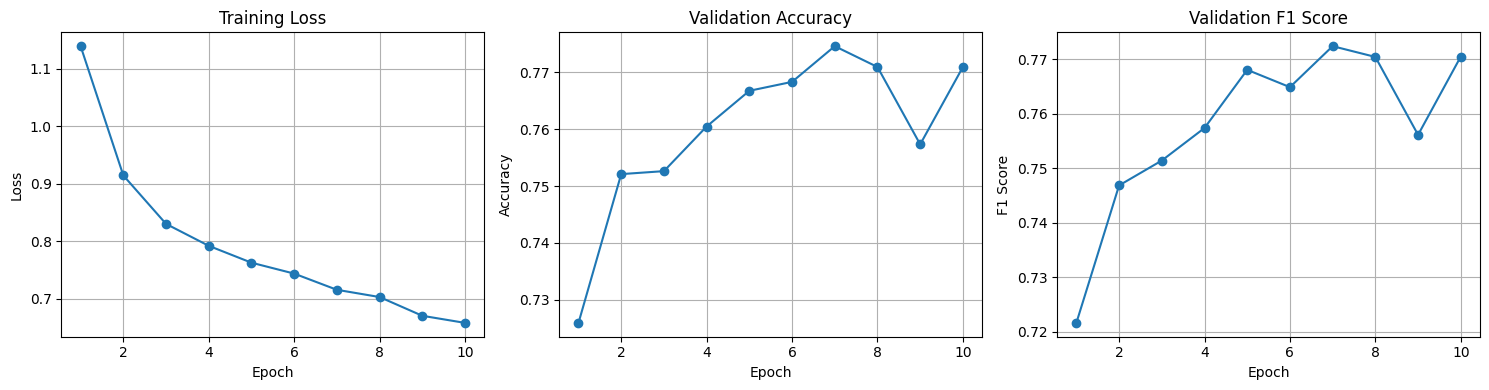

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from google.colab import drive
import random
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)), #preprocessing
    transforms.RandomHorizontalFlip(),  # Data augmentation: flip
    transforms.RandomRotation(15),     # Data augmentation: rotate
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Data augmentation: jitter
    transforms.CenterCrop(224), #  Resize: cleaning/preprocessing
    transforms.ToTensor(), #  Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder('/content/drive/My Drive/state_dataset/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder('/content/drive/My Drive/state_dataset/valid', transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Improved Model Only
class ImprovedFoodClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet50 = models.resnet50(pretrained=True) #Residual Connections
        for param in self.resnet50.parameters():
            param.requires_grad = False  # freeze feature extractor

        self.resnet50.fc = nn.Sequential(
            nn.Linear(2048, 256),
            nn.BatchNorm1d(256),  # Batch normalization: normalize activations
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),     # Dropout: reduce overfitting
            nn.Linear(256, 11)
        )

    def forward(self, x):
        return self.resnet50(x) #residuals

# Shared training function
def train_model(model, dataloader, criterion, optimizer, device, epochs=1):
    model.to(device)
    model.train()
    loss_list = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloader)
        loss_list.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    return epoch_loss

# Shared evaluation function
def evaluate_model(model, dataloader, device):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(f"Validation Accuracy: {100 * correct / total:.2f}%")
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')  # or 'macro' for balanced classes
    return accuracy, f1
#graph plotting function
def plot_training_metrics(losses, accuracies, f1_scores):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracies, marker='o')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1_scores, marker='o')
    plt.title('Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
# -------------------------
# Run Improved Model
# -------------------------
print("\nTraining Improved Model\n")
improved_model = ImprovedFoodClassifier()
improved_criterion = nn.CrossEntropyLoss()

#Learning rate adjustable. Just change the variable value
learning_rate = 0.001
improved_optimizer = torch.optim.Adam(improved_model.resnet50.fc.parameters(), lr=learning_rate)

# Tracking metrics
num_epochs = 10
losses = []
accuracies = []
f1_scores = []

# Per-epoch training and evaluation
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train for 1 epoch
    epoch_loss = train_model(improved_model, train_loader, improved_criterion, improved_optimizer, device, epochs=1)
    losses.append(epoch_loss)
    print(f"Training Loss: {epoch_loss:.4f}")

    # Evaluate after each epoch
    acc, f1 = evaluate_model(improved_model, valid_loader, device)
    accuracies.append(acc)
    f1_scores.append(f1)



plot_training_metrics(losses, accuracies, f1_scores)

#train_model(improved_model, train_loader, improved_criterion, improved_optimizer, device)
#evaluate_model(improved_model, valid_loader, device)

In [ ]:
# Assuming 'improved_model' is the instance of your ImprovedFoodClassifier
torch.save(improved_model.state_dict(), 'trained_model.pth')

# Training Scripts

In [ ]:
#Train Script

classifier = FoodImageClassifier()
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
#accuracy(classifier, valid_dataset, valid_loader) #accuracy before training
train(classifier, train_loader)
accuracy(classifier, valid_dataset, valid_loader) #accuracy after training

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

Loss: 2.390777111053467
Loss: 2.397932291030884
Loss: 2.3931188583374023
Loss: 2.4008359909057617
Loss: 2.382817029953003
Loss: 2.3978946208953857
Loss: 2.3995587825775146
Loss: 2.3930110931396484
Loss: 2.3857526779174805
Loss: 2.388192653656006
Loss: 2.384462594985962
Loss: 2.3910341262817383
Loss: 2.3772380352020264
Loss: 2.381511926651001
Loss: 2.384704113006592
Loss: 2.388383626937866
Loss: 2.380983591079712
Loss: 2.3674421310424805
Loss: 2.3828465938568115
Loss: 2.3740968704223633
Loss: 2.3750879764556885
Loss: 2.3665883541107178
Loss: 2.3734288215637207
Loss: 2.380038022994995
Loss: 2.36863112449646
Loss: 2.3691837787628174
Loss: 2.3883116245269775
Loss: 2.3301033973693848
Loss: 2.3548710346221924
Loss: 2.3634917736053467
Loss: 2.359714984893799
Loss: 2.3762035369873047
Loss: 2.366626262664795
Loss: 2.3719727993011475
Loss: 2.3390398025512695
Loss: 2.342532157897949
Loss: 2.3229334354400635
Loss: 2.328624963760376
Loss: 2.341240882873535
Loss: 2.3479745388031006
Loss: 2.333042383

KeyboardInterrupt: 

In [ ]:
torch.save(classifier.state_dict(), 'trained_model.pth') # Changed 'model' to 'classifier'
print("Model weights saved to 'trained_model.pth'")



In [ ]:
# load saved weights
classifier.load_state_dict(torch.load('trained_model.pth')) #Changed 'model' to 'classifier'
classifier.eval()  # Set the model to evaluation mode

# Testing Scripts

In [ ]:
#Initialize validation dataset
classifier = FoodImageClassifier()
valid_dataset = FoodImageClassificationDataset("/content/drive/My Drive/state_dataset/valid")
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
classifier.load_state_dict(torch.load('trained_model.pth')) #Changed 'model' to 'classifier'

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


{'creamy_paste': 0, 'diced': 1, 'floured': 2, 'grated': 3, 'juiced': 4, 'jullienne': 5, 'mixed': 6, 'other': 7, 'peeled': 8, 'sliced': 9, 'whole': 10}


<All keys matched successfully>

In [ ]:
# Test the model on the entire validation dataset
accuracy(classifier, valid_dataset, valid_loader)

Correct this iter: 18, Running total: 18
Correct this iter: 19, Running total: 37
Correct this iter: 19, Running total: 56
Correct this iter: 7, Running total: 63
Correct this iter: 21, Running total: 84
Correct this iter: 22, Running total: 106
Correct this iter: 25, Running total: 131
Correct this iter: 26, Running total: 157
Correct this iter: 25, Running total: 182
Correct this iter: 20, Running total: 202
Correct this iter: 25, Running total: 227
Correct this iter: 28, Running total: 255
Correct this iter: 26, Running total: 281
Correct this iter: 22, Running total: 303
Correct this iter: 25, Running total: 328
Correct this iter: 20, Running total: 348
Correct this iter: 26, Running total: 374
Correct this iter: 18, Running total: 392
Correct this iter: 27, Running total: 419
Correct this iter: 27, Running total: 446
Correct this iter: 27, Running total: 473
Correct this iter: 25, Running total: 498
Correct this iter: 29, Running total: 527
Correct this iter: 20, Running total: 54

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


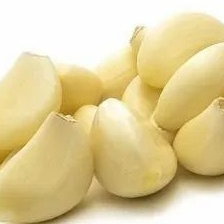

Prediction: jullienne, Label: peeled


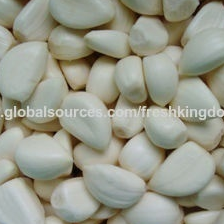

Prediction: peeled, Label: peeled


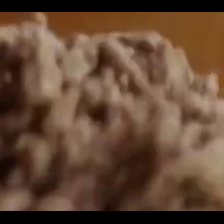

Prediction: other, Label: grated


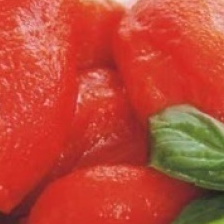

Prediction: jullienne, Label: peeled


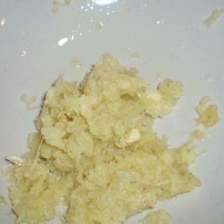

Prediction: other, Label: grated


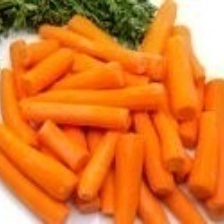

Prediction: diced, Label: peeled


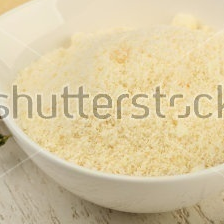

Prediction: jullienne, Label: grated


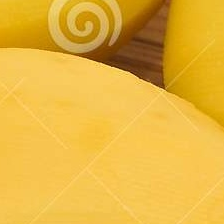

Prediction: jullienne, Label: peeled


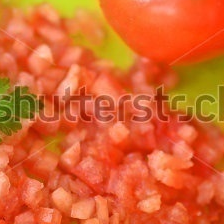

Prediction: diced, Label: diced


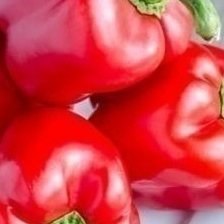

Prediction: jullienne, Label: whole
Accuracy: 20.0 %


In [ ]:
# Test the model on a small sample
classifier = FoodImageClassifier()
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
classifier.load_state_dict(torch.load('trained_model.pth')) #Changed 'model' to 'classifier'

test(FoodImageClassifier(), valid_dataset, 10)